# A3Data - Desafio Técnico Cientista de Dados

**Candidato: Carlos Alberto Stefano Filho**

Este notebook propõe uma solução para o desafio técnico de Cientista de Dados da A3Data, com objetivo de auxiliar na redução do churn de uma empresa de telecomunicações.

Este notebook estrutura-se segundo as seguintes seções:


___
## 1. Passos iniciais
### 1.1 Importação de bibliotecas e leitura da base de dados

In [ ]:
import pandas as pd
import numpy as np

from google.colab import files
from scipy.stats import pointbiserialr, mannwhitneyu

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest

In [ ]:
uploaded = files.upload()

Saving Customer-Churn.xlsx to Customer-Churn.xlsx


### 1.2. Familiarização com o conjunto de dados

In [ ]:
# Leitura da base de dados em xlsx
df = pd.read_excel('Customer-Churn.xlsx')

# Conversão de delimitador decimal de colunas de conteúdo numérico)]
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].str.replace(',', '.').astype(float, errors='ignore')

In [ ]:
df.shape

(7043, 21)

In [ ]:
df["customerID"].nunique() # contagem de ID's únicos na base de consumidores

7043

Vemos que a base de dados possui 7043 entradas, cada uma possivelmente associada a um "customerID" único. Além disso, há 21 colunas na tabela, conforme será detalhado a seguir.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


Com as duas células anteriores, vemos, portanto, que a base de dados possui um total de 7043 entradas, e que apenas a coluna "TotalCharges" possui 11 entradas nulas, o que representa apenas 0.2% do total de entradas, aproximadamente. Posteriormente, faremos a discussão acerca de possíveis tratamentos destas entradas nulas.

Em todo caso, todas as outras colunas apresentaram 100% dos valores como não nulos.

___
## 2. Análise Exploratória de Dados


### 2.1. Avaliações exploratórias iniciais

Para iniciar a análise exploratória de dados, primeiramente, façamos uma visualização do percentual de clientes que apresentaram churn na base de dados, em relação ao total, para que possamos ter visibilidade de possíveis desbalanceamentos nas proporções de classes de clientes do problema (churn e não churn), além de obter a representatividade de churn, na base, a um nível geral.

In [ ]:
def set_spines_visibility_off(ax, spines_to_set):
  for spine in spines_to_set:
    ax.spines[spine].set_visible(False)

<ipython-input-8-3fbc46d89af0>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["Sim", "Não"])


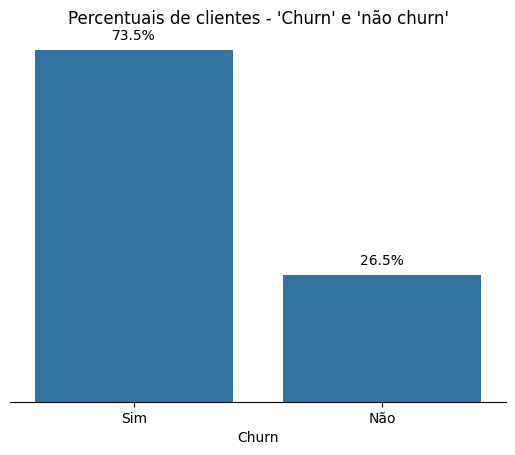

In [ ]:
ax = sns.countplot(data = df,
                   x = 'Churn',
                   stat = 'percent')
ax.set_title("Percentuais de clientes - 'Churn' e 'não churn'")
set_spines_visibility_off(ax, ["left", "top", "right"])
ax.yaxis.set_visible(False)

ax.set_xticklabels(["Sim", "Não"])
for p in ax.patches:
    ax.annotate(f'{np.round(p.get_height(),1)}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

Da figura acima, concluimos que, da base de clientes disponível, 26.5% representaram problemas de churn para a empresa cliente da consultoria, uma fração considerável, de pouco mais de um quarto do total de clientes.

Logo, faz-se importante compreender que fatores do comportamento destes clientes podem estar mais relacionados às maiores chances de ocorrência de churn, a partir o histórico de interação que a empresa de telefonia possui, que se assume presente nas bases de dados fornecidas. Para tal, relembremos as colunas que compõem a tabela.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


Nota-se que a maior parte das variáveis é categórica, com apenas quatro delas sendo numéricas e não categóricas; a saber: *tenure*, *montlhyCharges* e *totalCharges*.

Para prosseguir com a avaliação, a seguir, faremos o *encoding* das variáveis categóricas e, dada a natureza das relações que buscamos, aplicaremos a correlação ponto-bisserial para estimar índices de relacionamento estatístico entre as variáveis do problema, com enfoque especial para as correlações com a variável 'Churn'.

#### 2.2. Correlações

Antes de passarmos ao cálculo das correlações em si, voltemos à questão dos valores nulos.

Conforme pode ser verificado a seguir, todos os casos em que há valores nulos na base de dados correspondem a clientes que não apresentaram 'churn', que são o grupo majoritário da base. Além disso, a proporção é razoavelmente pequena em relação ao total (aproximadamente 0.2%, conforme previamente mencionado).

Apesar de existirem diversas possibilidades que poderiam solucionar a problemática dos valores nulos neste caso, como preenchê-los com a média, ou amostrando a partir de uma distribuição adequada dos dados, em todo caso, são critérios com algum nível de arbitrariedade.

Assim, para evitar tais critérios, dada a baixa proporção de valores faltantes, optamos por seguir a análise descartando essas entradas. Como a proporção de 0.2% é razoavelmente baixa, o descarte destas amostras deverá possuir pouco impacto no desenvolvimento geral da análise.


In [ ]:
 df[df["TotalCharges"].isna()] # visualizando os clientes com valores nulos na coluna 'TotalCharges'

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
2531,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
3343,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,No
4023,2775-SEFEE,Male,0,No,Yes,0,Yes,Yes,DSL,Yes,...,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),61.90,NaN,No
4315,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No
4583,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
5484,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,No
5549,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,No
6213,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No
6429,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,No
6562,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,No


In [ ]:
df2 = df.dropna()
df2.shape

(7032, 21)

Com as 11 entradas nulas removidas da base de dados, continuemos para a avaliação de correlações. Conforme explicitado, seguiremos com a correlação ponto-bisserial, por ter sido apontada como adequada para correlações entre variáveis dictômicas, e entre dictômicas e contínuas (ver, por exemplo, https://journals.sagepub.com/doi/10.1177/8756479308317006)

In [ ]:
def pointbiserial_corr(x,y):
  return pointbiserialr(x,y)[0]

In [ ]:
df2 = pd.get_dummies(df2.drop(columns = "customerID"), drop_first = True)

In [ ]:
df2.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,...,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn_Yes
0,0,72,118.75,8672.45,False,True,True,True,False,True,...,True,False,True,False,True,True,False,False,False,False
1,0,71,118.65,8477.60,False,False,False,True,False,True,...,True,False,True,False,True,True,False,True,False,False
2,0,68,118.60,7990.05,False,True,False,True,False,True,...,True,False,True,False,True,False,False,False,True,False
3,0,61,118.60,7365.70,False,False,False,True,False,True,...,True,False,True,True,False,True,False,True,False,False
4,0,67,118.35,7804.15,True,False,False,True,False,True,...,True,False,True,True,False,True,False,False,False,True


Com a aplicação do método *get_dummies* como feito acima, obtemos um *encoding* de *k-1* variáveis representando todas as categorias possíveis das características categóricas (já que utilizamos a opção de remover a primeira categorização, principalmente pela considerável quantidade de variáveis binárias).

Na sequência, realizamos o plot das correlações após agrupamento hierárquico, para facilitar a visualização, apenas.

In [ ]:
R = df2.corr(method = pointbiserial_corr)

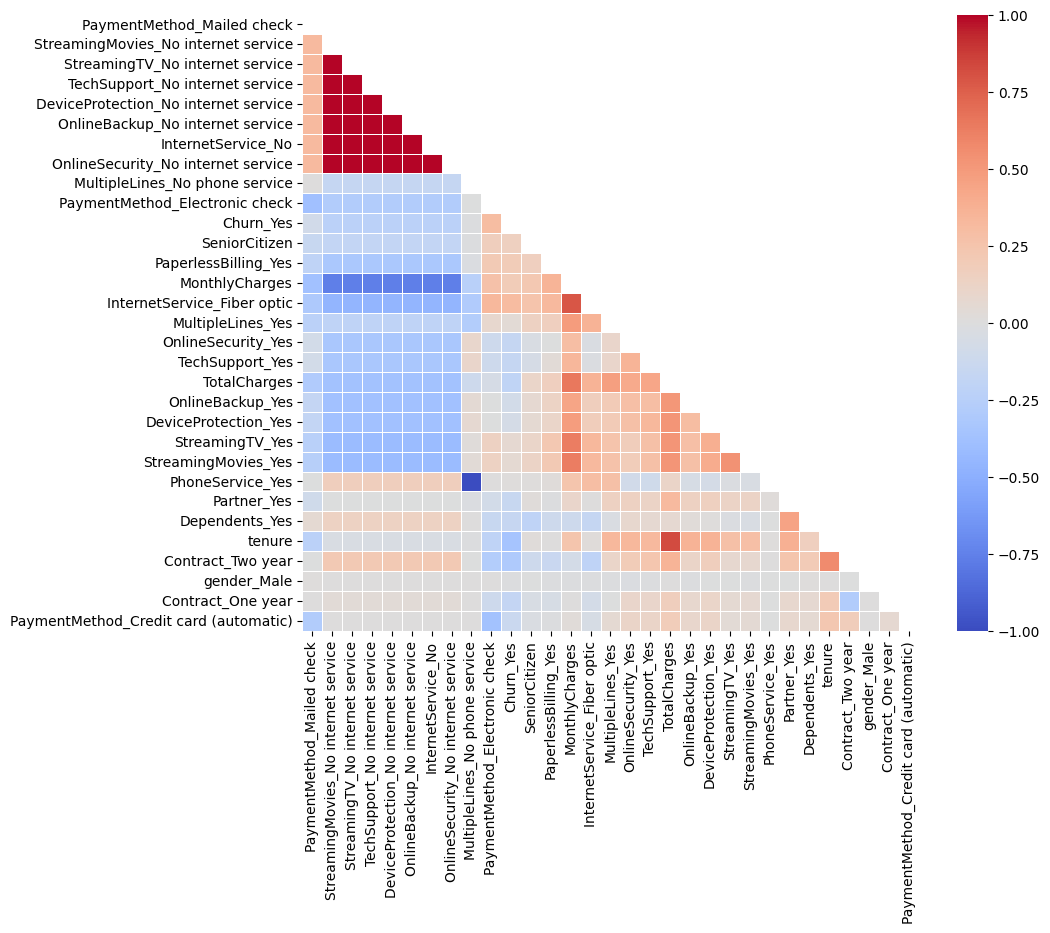

In [ ]:
# Criando o agrupamento hierárquico e o clustermap
clustergrid = sns.clustermap(R, cmap='coolwarm', method='average', metric='euclidean', figsize=(10, 8))
plt.close()

# Extraindo a ordem das filas e colunas reordenadas
reordered_corr = R.iloc[clustergrid.dendrogram_row.reordered_ind, clustergrid.dendrogram_col.reordered_ind]

# Criando uma máscara para a matriz triangular inferior
mask = np.triu(np.ones_like(reordered_corr, dtype=bool))

# Criando o heatmap com a matriz reordenada e a máscara aplicada
plt.figure(figsize=(10, 8))
sns.heatmap(reordered_corr, mask= mask, cmap='coolwarm', square=True, linewidths=.5)
plt.show()

Com a visualização das correlações conforme posta acima, conseguimos identificar algumas regiões da matriz com predominâncias de correlações positicas e negativas: algumas características marcadas como positivas ("Yes"), como possuir serviços de backup online e de streaming de TV da operadora se correlacionam negativamente com não ("No") utilizar serviços de terceiros em tecnologias como streaming de TV e de filmes. Outras comparações análogas poderiam ser feitas com outras regiões da matriz.

Podemos, ainda, destacar especificamente as correlações com o fato de o cliente ter apresentado churn.

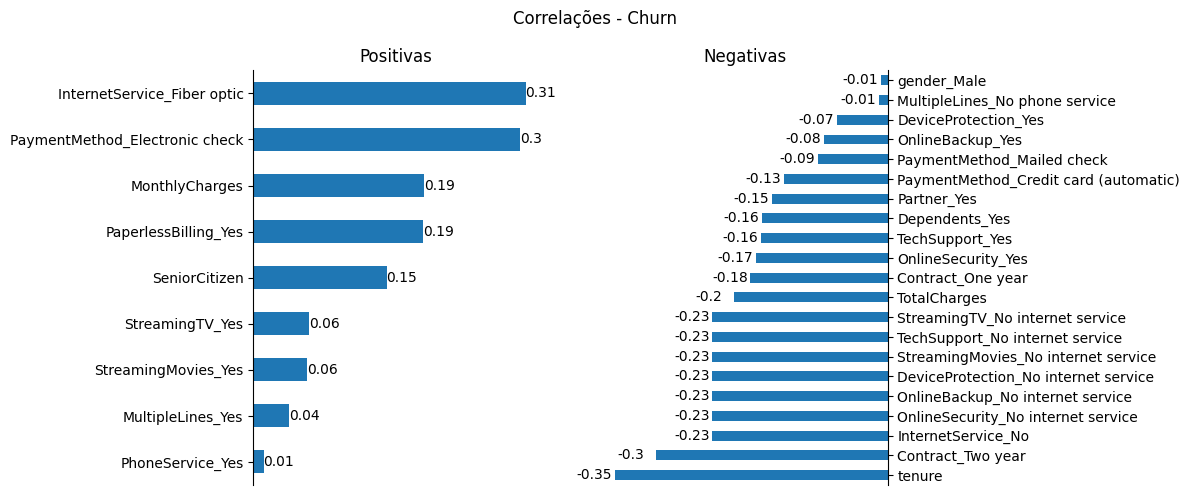

In [ ]:
fig, ax = plt.subplots(1,2, figsize = (12,5))

R[R["Churn_Yes"] >= 0]["Churn_Yes"].drop("Churn_Yes").sort_values(ascending = True).plot(kind = 'barh', ax = ax[0])
for index, value in enumerate(R[R["Churn_Yes"] >= 0]["Churn_Yes"].drop("Churn_Yes").sort_values(ascending = True)):
    ax[0].text(value, index, str(np.round(value,2)), ha='left', va='center')
set_spines_visibility_off(ax[0], ["top", "right", "bottom"])
ax[0].xaxis.set_visible(False)

R[R["Churn_Yes"] < 0]["Churn_Yes"].sort_values(ascending = True).plot(kind = 'barh', ax = ax[1])
for index, value in enumerate(R[R["Churn_Yes"] < 0]["Churn_Yes"].sort_values(ascending = True)):
    ax[1].text(value - 0.05, index, str(np.round(value,2)), ha='left', va='center')
set_spines_visibility_off(ax[1], ["top", "left", "bottom"])
ax[1].xaxis.set_visible(False)
ax[1].yaxis.tick_right()
ax[1].yaxis.set_label_position("right")


ax[0].set_title("Positivas")
ax[1].set_title("Negativas")
plt.suptitle("Correlações - Churn")
plt.tight_layout()

O gráfico anterior, de correlações, sumariza bem algumas informações, como:
- clientes com serviço de Fibra Óptica, cujo método de pagamento seja por "cheques eletrônicos", e com maiores cobranças mensais, tendem a apresentar churns com mais frequência;
- clientes com 65 anos ou mais ('SeniorCitizens') também parecem mais propensos a churn do que clientes mais jovens;
- por outro lado, clientes com maior tempo de fidelidade com a companhia, materializado, aqui, pelas características 'tenure' e Contract_Two Year', tendem a apresentar churns com menos frequência;
- características relacionadas a possuir streaming de TV e filmes ('StreamingMovies_Yes' e 'StreamingTV_Yes'), alguns serviços telefônicos ('MultipleLines_Yes', 'PhoneService_Yes') e gênero ('gender_Male'), parecem possuir pouco impacto para influenciar um cliente ao churn.

Em linhas gerais, o gráfico de correlações permite que avaliemos tendências em relação às características que parecem influenciar mais, ou menos, no churn para um determinado tipo de cliente.

Continuando a explorar um pouco melhor esses aspectos, poderíamos, por exemplo, avaliar as distribuições de algumas dessas variáveis conforme o churn para a base de clientes, conforme abaixo.

Text(0.5, 0.98, 'Avaliações de Churn')

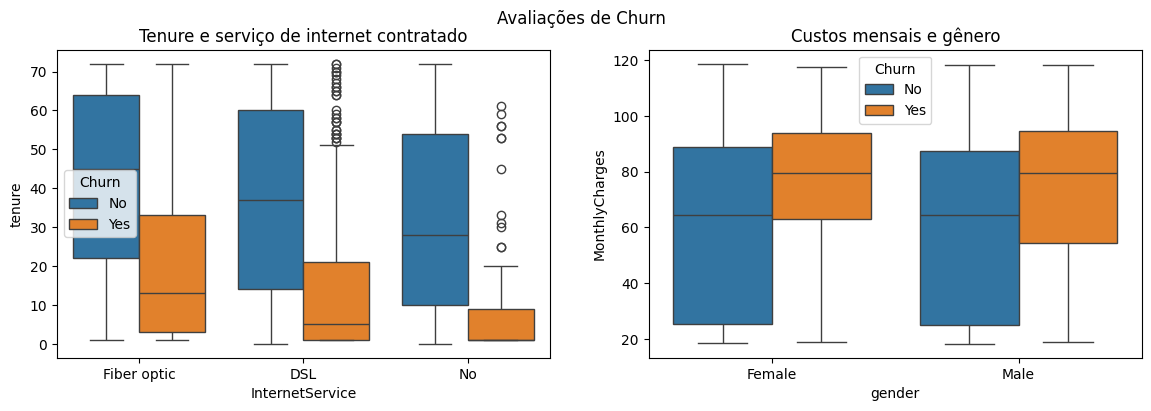

In [ ]:
_, ax = plt.subplots(1,2, figsize = (14,4))

sns.boxplot(data = df,
               x = "InternetService",
               y = "tenure",
               ax = ax[0],
               hue = "Churn")
ax[0].set_title("Tenure e serviço de internet contratado")

sns.boxplot(data = df,
               x = "gender",
               y = "MonthlyCharges",
               hue = "Churn")
ax[1].set_title("Custos mensais e gênero")

plt.suptitle("Avaliações de Churn")

In [ ]:
def mannwhitneyu_test(filter_conditions, churn_conditions, feature_to_compare, message):
  U, p = mannwhitneyu(df[(df[filter_conditions['variable']] == filter_conditions['A']) & (df["Churn"] == churn_conditions['A'])][feature_to_compare],
                    df[(df[filter_conditions['variable']] == filter_conditions['B']) & (df["Churn"] == churn_conditions['B'])][feature_to_compare])
  print(f"Teste de Mann-Whitney com estatística de {np.floor(U)} e p-valor = {np.round(p,2)}.")
  print(f"Condições testadas: clientes {message[0]}, contrastando os valores de '{feature_to_compare}' entre {message[1]}.")

In [ ]:
mannwhitneyu_test(filter_conditions = {"variable": "InternetService",
                                       "A": "Fiber optic",
                                       "B": "Fiber optic"},
                  churn_conditions = {'A': "Yes", 'B': "No"},
                  feature_to_compare = 'tenure',
                  message = ("com serviço de Fibra Óptica", "as condições de churn"))

Teste de Mann-Whitney com estatística de 550257.0 e p-valor = 0.0.
Condições testadas: clientes com serviço de Fibra Óptica, contrastando os valores de 'tenure' entre as condições de churn.


In [ ]:
mannwhitneyu_test(filter_conditions = {"variable": "InternetService",
                                       "A": "Fiber optic",
                                       "B": "DSL"},
                  churn_conditions = {'A': "Yes", 'B': "Yes"},
                  feature_to_compare = 'tenure',
                  message = ("que apresentaram churn", "os serviços de Fibra Óptica e DSL"))

Teste de Mann-Whitney com estatística de 361195.0 e p-valor = 0.0.
Condições testadas: clientes que apresentaram churn, contrastando os valores de 'tenure' entre os serviços de Fibra Óptica e DSL.


In [ ]:
mannwhitneyu_test(filter_conditions = {"variable": "gender",
                                       "A": "Female",
                                       "B": "Male"},
                  churn_conditions = {'A': "Yes", 'B': "Yes"},
                  feature_to_compare = 'MonthlyCharges',
                  message = ("que apresentaram churn", "os gêneros"))

Teste de Mann-Whitney com estatística de 439328.0 e p-valor = 0.82.
Condições testadas: clientes que apresentaram churn, contrastando os valores de 'MonthlyCharges' entre os gêneros.


A distribuição vista a partir dos boxplots da figura anterior ilustra alguns dos achados supramencionados para a correlação, isto é:
- para o gráfico da esquerda ('tenure' e 'InternetService'), mesmo qualitativamente, notamos um impacto no tipo de serviço contratado e churn. Isto é evidenciado pela tendência de, para Fibra Óptica, por exemplo, o terceiro quartil de 'tenure' ser maior que para os outros dois casos, indicando que, para esta modalidade, mesmo clientes que estejam com a companhia há um certo tempo parecem mais propensos a churn que para o serviço de DSL. Neste último caso, por exemplo, valores a partir de 50 para a variável 'tenure' já passam a ser considerados outliers, o que não ocorre para os clientes cuja assinatura é de Fibra Óptica. Isto se relaciona à correlação razoavelmente alta para a variável associada à assinatura de Fibra Óptica do gráfico anterior. Por fim, também verificamos diferença estatisticamente significante entre as condições de churn para os clientes com assinatura por Fibra Óptica (p < 0.05; teste de Mann-Whitney).
- para o gráfico da direita ('MonthlyCharges' e 'gender'), observa-se como a segmentação em gênero, mesmo qualitativamente, parece insignificante para trazer qualquer tipo de insight acerca de predição de churn, em linha com o baixo valor de correlação encontrado para a variável de gênero e churn (- 0.01). Ademais, fixando a condição de o cliente ter apresentado churn, não verificamos diferença estatisticamente significante entre os gêneros (p = 0.82; teste de Mann-Whitney), reforçando a falta de impacto do gênero neste cenário. Além disso, a cobrança mensal parece ter maior impacto, evidenciado pela tendência de maiores medianas para a variável 'MonthlyCharges' para o grupo de clientes que foi a churn, sugerindo impacto considerável desta variável para o problema (correlação de 0.19).

Os exemplos anteriores demonstram alguns resultados representativos, sendo que várias outras combinações que seguissem o mesmo raciocínio poderiam ser possíveis.

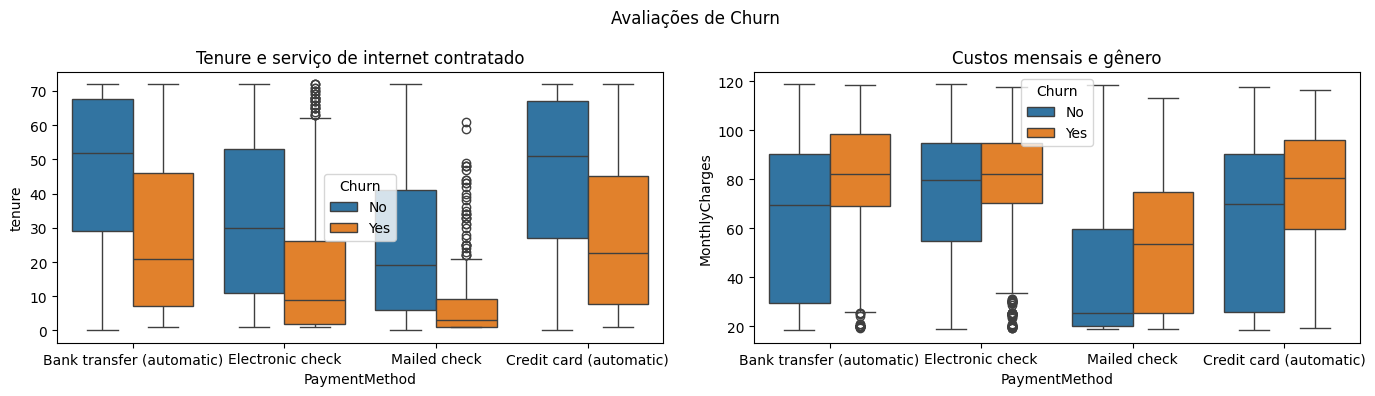

In [ ]:
_, ax = plt.subplots(1,2, figsize = (14,4))

sns.boxplot(data = df,
               x = "PaymentMethod",
               y = "tenure",
               ax = ax[0],
               hue = "Churn")
ax[0].set_title("Tenure e serviço de internet contratado")

sns.boxplot(data = df,
               x = "PaymentMethod",
               y = "MonthlyCharges",
               hue = "Churn")
ax[1].set_title("Custos mensais e gênero")

plt.suptitle("Avaliações de Churn")
plt.tight_layout()

In [ ]:
mannwhitneyu_test(filter_conditions = {"variable": "PaymentMethod",
                                       "A": "Bank transfer (automatic)",
                                       "B": "Electronic check"},
                  churn_conditions = {'A': "Yes", 'B': "Yes"},
                  feature_to_compare = 'tenure',
                  message = (", independentemente do serviço", "as condições de pagamento"))

Teste de Mann-Whitney com estatística de 177301.0 e p-valor = 0.0.
Condições testadas: clientes , independentemente do serviço, contrastando os valores de 'tenure' entre as condições de pagamento.


Vemos, neste caso, por exemplo, como parece existir uma tendência de, ao avaliarmos a variável 'tenure' (à esquerda do gráfico acima), clientes cujo método de pagamento seja de transferência bancára tenderem a possuirem maiores valores de 'tenure', do que, por exemplo, o pagamento por cheque eletrônico (p < 0.05; teste de Mann-Whitney).

Este tipo de visualização, portanto, permite inferir sobre possíveis tendências na base de dados.

### 2.2. Outras explorações

Anteriormente, comentamos brevemente acerca da importância de considerar as relações entre as varáveis do conjunto de dados. De fato, isso pode ser evidenciado explorando a relação, por exemplo, entre "TotalCharges" e 'tenure', conforme abaixo.

Neste caso, vê-se uma tendência linear entre as duas variáveis, mas com aparente grau de heterocidesticidade, que talvez possa ser explicado caso consideremos a interação entre variáveis do problema. Apenas a segmentação entre 'churn' ou 'não churn' não é suficiente para explicar o fenômeno, apesar de, qualitativamente, parecer existir uma tendência por clientes que apresentaram churn se concentrarem nas porções mais superiores do gráfico de dispersão, e para os menores valores de 'tenure'.

Text(0.5, 1.0, "Distribuições - 'TotalCharges'")

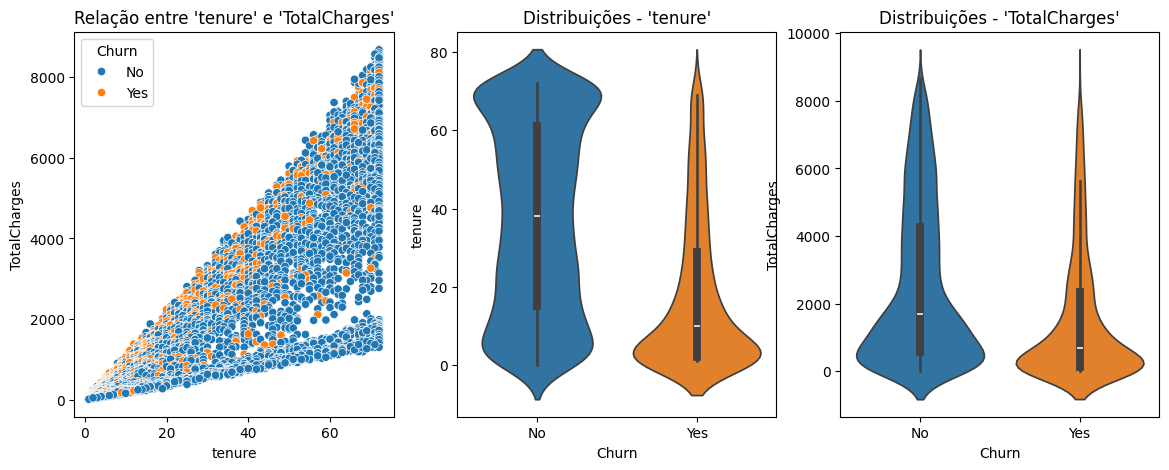

In [ ]:
_, ax = plt.subplots(1,3,figsize = (14,5))

sns.scatterplot(data = df,
            x = "tenure",
            y = "TotalCharges",
            hue = "Churn",
            ax = ax[0])
ax[0].set_title("Relação entre 'tenure' e 'TotalCharges'")

sns.violinplot(data = df,
            x = 'Churn',
            y = "tenure",
            hue = "Churn",
            ax = ax[1])
ax[1].set_title("Distribuições - 'tenure'")

sns.violinplot(data = df,
            x = 'Churn',
            y = "TotalCharges",
            hue = "Churn",
            ax = ax[2])
ax[2].set_title("Distribuições - 'TotalCharges'")

Para referência, a seguir, faremos algumas visualizações de dados com as características mais correlacionadas à variável indicativa de churn.

#### Tempo de 'tenure' e churn

<ipython-input-27-f3e7f8816949>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(["Não", "Sim"])
<ipython-input-27-f3e7f8816949>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(["Não", "Sim"])


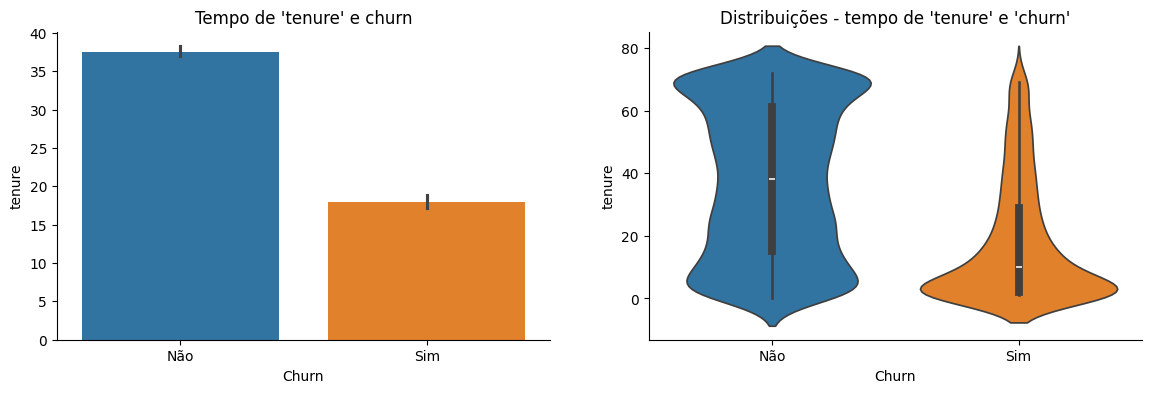

In [ ]:
_, ax = plt.subplots(1,2, figsize = (14,4))
sns.barplot(data = df,
            x = 'Churn',
            y = 'tenure',
            hue = 'Churn',
            ax = ax[0])
ax[0].set_title("Tempo de 'tenure' e churn")
ax[0].set_xticklabels(["Não", "Sim"])
set_spines_visibility_off(ax[0], ["top", "right"])

sns.violinplot(data = df,
               x = 'Churn',
               y = 'tenure',
               hue = 'Churn',
               ax = ax[1])
ax[1].set_title("Distribuições - tempo de 'tenure' e 'churn'")
ax[1].set_xticklabels(["Não", "Sim"])
set_spines_visibility_off(ax[1], ["top", "right"])

O gráfico acima enfatiza a correlação negativa com entre 'tenure' e a variável indicativa de churn, ou seja: clientes com os maiores tempos de 'tenure', em geral, tendem a apresentarem menor churn.

#### Contrato e serviço de internet

<ipython-input-28-aa2b4a9bc76f>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(["Não", "Sim"])
<ipython-input-28-aa2b4a9bc76f>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(["Não", "Sim"])


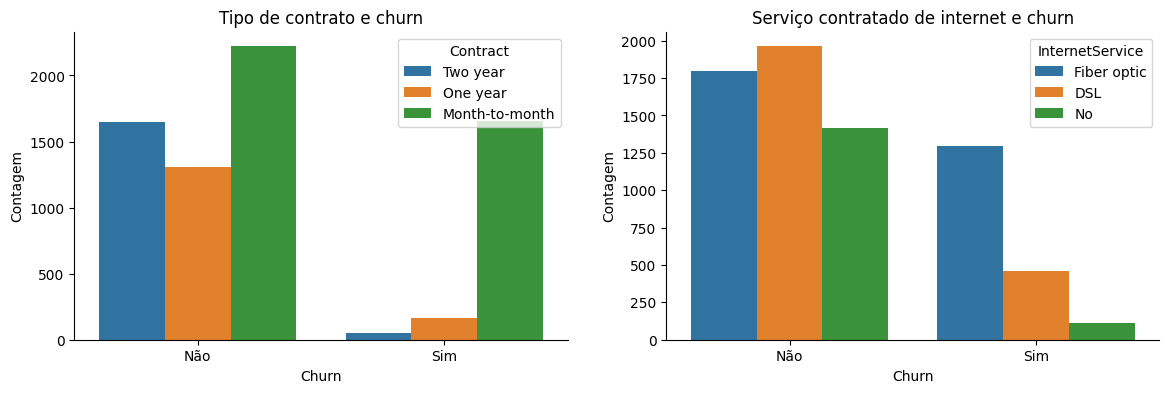

In [ ]:
_, ax = plt.subplots(1,2, figsize = (14,4))
sns.countplot(data = df,
            x = 'Churn',
            hue = 'Contract',
            ax = ax[0])
ax[0].set_title("Tipo de contrato e churn")
ax[0].set_xticklabels(["Não", "Sim"])
ax[0].set_ylabel("Contagem")
set_spines_visibility_off(ax[0], ["top", "right"])

sns.countplot(data = df,
               x = 'Churn',
               hue = 'InternetService',
               ax = ax[1])
ax[1].set_title("Serviço contratado de internet e churn")
ax[1].set_xticklabels(["Não", "Sim"])
ax[1].set_ylabel("Contagem")
set_spines_visibility_off(ax[1], ["top", "right"])

Vemos, do gráfico acima, como o tipo de contrato também pode impactar no churn,De fato, os clientes com contratos mensais tendem a apresentar bem mais churn que os outros tipos de contratação.

Além disso, em relação ao serviço contratado, algo similar ocorre para o serviço de fibra óptica.

#### Método de pagamento e cidadãos idosos


<ipython-input-29-27173f1b95d8>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(["Não", "Sim"])
<ipython-input-29-27173f1b95d8>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(["Não", "Sim"])


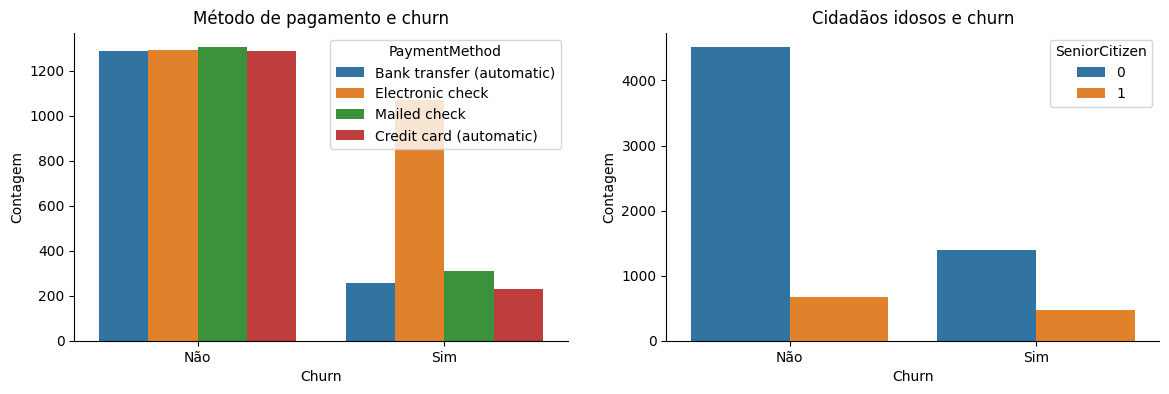

In [ ]:
_, ax = plt.subplots(1,2, figsize = (14,4))
sns.countplot(data = df,
            x = 'Churn',
            hue = 'PaymentMethod',
            ax = ax[0])
ax[0].set_title("Método de pagamento e churn")
ax[0].set_xticklabels(["Não", "Sim"])
ax[0].set_ylabel("Contagem")
set_spines_visibility_off(ax[0], ["top", "right"])

sns.countplot(data = df,
               x = 'Churn',
               hue = 'SeniorCitizen',
               ax = ax[1],
              )
ax[1].set_title("Cidadãos idosos e churn")
ax[1].set_xticklabels(["Não", "Sim"])
ax[1].set_ylabel("Contagem")
set_spines_visibility_off(ax[1], ["top", "right"])

### 2.3. Sumarizando: quem são os clientes com maiores chances de churn?

De acordo com o que foi discutido desta análise exploratória de dados, os clientes que possuiriam maiores propensões a churn seriam aqueles que:
- possuem menos tempo com a contratação do serviço;
- são assinantes do serviço de Fibra Óptica;
- possuem maiores cobranças mensais;
- possuem 65 anos ou mais ('SeniorCitizen').

Apesar de termos delineado algumas características importantes que podem servir de enfoque para entender para quais clientes poderiam ser direcionados os maiores esforços para prevenção de churn, por exemplo, ainda assim, faltam alguns "pontos de corte" importantes para que se possam ter recomendações mais diretas e objetivas. Além disso, é importante considerar o efeito da interação entre as diferentes variáveis - as características de 'tenure' e 'MonthlyCharge', por exemplo, são altamente correlacionadas, mas nossa abordagem até o momento enfoca, em mais detalhes, a interação de cada variável com o fato de o cliente ter, ou não, apresentado churn.

Isto posto, na sequência, introduziremos um modelo de Machine Learning para auxiliar, justamente, na determinação destes pontos de cortes e na predição do problema de churn. Poderemos, assim, confrontar a importância de cada feature do modelo à análise desenvolvida na seção exploratória.

___
## 3. Sistematização da predição de churn por modelos preditivos

Como uma etapa adicional, e visando capturar melhor o relacionamento entre as variáveis da base de dados, utilizaremos um classificador do tipo *RandomForest* como uma primeira aproximação para solucionar o problema de previsão de clientes mais propensos a churn.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

Faremos uma validação cruzada para encontrar o número ótimo de atributos, que serão ordenados a partir dos índices de correlação com a variável indicativa de churn, que serão recalculados apenas para o subconjunto de treinamento. Subsequentemente, faremos a avaliação do resultado final na base de testes.

In [ ]:
X, y = df2.drop(columns = "Churn_Yes"), df2["Churn_Yes"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
C = abs(pd.concat([X_train, y_train], axis = 1).corr(method = pointbiserial_corr)["Churn_Yes"].drop("Churn_Yes")).sort_values(ascending = False )

roc_auc_val = {}

for k in range(1,15):
  print(f"Now running for k = {k}")
  X_train_kbest = X_train[C.index[0:k]]

  # Treinar a árvore de decisão usando as características selecionadas
  tree_classifier = RandomForestClassifier(class_weight = {False: 1, True: 4})
  cv = cross_val_score(estimator = tree_classifier,
                       X = X_train_kbest,
                       y = y_train,
                       scoring = 'roc_auc',
                       cv = 5)

  roc_auc_val[k] = np.mean(cv)

Now running for k = 1
Now running for k = 2
Now running for k = 3
Now running for k = 4
Now running for k = 5
Now running for k = 6
Now running for k = 7
Now running for k = 8
Now running for k = 9
Now running for k = 10
Now running for k = 11
Now running for k = 12
Now running for k = 13
Now running for k = 14


In [ ]:
roc_df = pd.DataFrame(roc_auc_val, index = [0]).transpose().rename(columns = {0: 'roc_auc'})
roc_df.set_index(C.index[0:14], inplace = True)

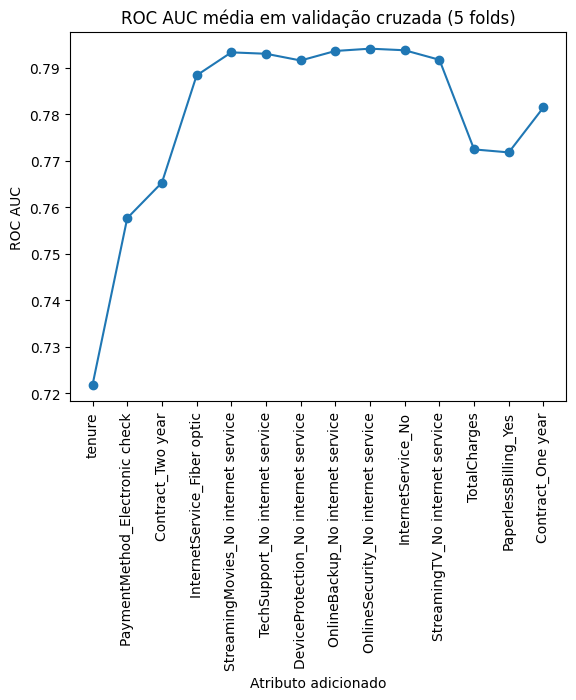

In [ ]:
ax = roc_df.plot(legend = False, marker = 'o')
ax.set_title("ROC AUC média em validação cruzada (5 folds)")
ax.set_ylabel("ROC AUC")
ax.set_xlabel("Atributo adicionado")
ax.set_xticks(np.arange(0,len(roc_df)))
ax.set_xticklabels(roc_df.index, rotation = 90);

No gráfico acima, é possível acompanhar a performance do classificador, mensurada segundo a métrica de ROC AUC, à medida que são adicionados novos atributos.

Em geral, nota-se um patamar bastante estável de performance no intervalo de utilização entre 5 a 11 features, que, em seguida, sofre quedas de performance conforme novos atributos foram adicionados.

Para dar sequência ao conjunto de testes, optamos por seguir com $k = 6$ atributos (maior simplicidade do modelo e performance comparável).

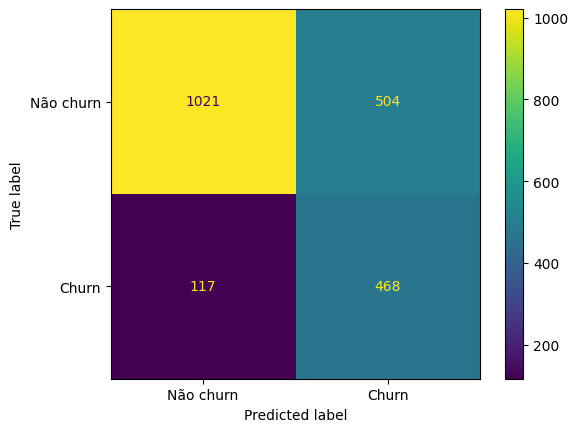

In [ ]:
RF = RandomForestClassifier(class_weight = {0: 1, 1: 4}) # atribuição de pesos para 'compensar' o desbalanceamento das classes de dados
RF.fit(X_train[C.index[0:6]], y_train)

y_pred = RF.predict(X_test[C.index[0:6]])
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm, display_labels = ["Não churn", "Churn"]).plot()

A partir da matriz de confusão, observa-se que:
- de todos os clientes que efetivamente apresentaram churn, nosso modelo é capaz de identificar, aproximadamente, 81.3% deles;
- de todos os clientes que nosso modelo identificou como com alto potencial de churn, aproximadamente 49.3% deles efetivamente apresentou churn.

Deste modo, vemos que, por um lado, a abordagem proposta é capaz de capturar uma fração considerável (pouco maior de 80%) dos clientes que apresentaram churn. No entanto, essencialmente metade dos clientes que o modelo identificar como com alto potencial de churn, não iriam a churn, de fato (assumindo que a base de testes do modelo seja minimamente representativa do comportamento em produção). A taxa de falsos positivos, assim, é razoavelmente elevada, apesar da boa sensibilidade em detectar os 80% dos clientes que poderiam apresentar churn.



___
## 4. Considerações gerais

Ao longo deste notebook, desenvovelmos uma série de investigações sobre o problema proposto de churn.

Na etapa de análise exploratória de dados, o enfoque foi pautado, essencialmente, em correlações do tipo ponto-bisserial entre cada par de variáveis do conjunto de dados. Em especial, enfatizamos as correlações com a variável indicativa de churn.

A análise revelou possíveis fatores que mais poderiam auxiliar a identificar clientes com maiores potenciais de churn. Dentre eles, destacamos: a variável 'tenure', os valores de cobranças mensais e a idade dos clientes ser maior que 65 anos, por exemplo.

Posteriormente, avaliamos a performance de um modelo do tipo Random Forest para classificar clientes com alto potencial de churn. O modelo, em uma primeira abordagem, foi capaz de identificar corretamente pouco mais de 80% dos casos de churn, embora com uma taxa razoável de falsos positivos. Entretanto, a identificação considerável dos 80% de clientes com alto potencial de churn poderia direcionar na execução de políticas especiais de retenção para os clientes assim identificados pelo modelo.

Ademais, iterações futuras para melhora do modelo já poderiam ser mapeadas, para investigar se sua performance poderia ser melhorada, minimizando as perdas para a empresa. Estas iterações poderiam contemplar:
- avaliação de outros modelos, além da Random Forest;
- ajuste fino dos hiperparâmetros do modelo;
- abordagens de oversampling ou downsampling para balanceamento da base de dados;
- ajustes finos dos pesos das classes no(s) modelo(s) e do número de atributos.

O modelo aqui desenvolvido, de todo modo, poderia ter sua utilizada e viabilidade avaliada para eventualmente ser posto em produção.